# Simple Spread
**Objectives**: The environment has N agents and N landmarks. Agents must learn to cover all the landmarks while avoiding collisions. All agents are globally rewarded based on how far the closest agents is to each landmark (sum of the minimum distances). The agents are penalised if they collide with other agents (-1 for each collision).

**Actions**:
 - Agent observations: `[self_vel, self_pos, landmark_rel_positions, other_agent_rel_positions, communication]`
 - Agent action space: `[no_action, move_left, move_right, move_down, move_up]`

In [1]:
import argparse
import os
from copy import deepcopy
from typing import Optional, Tuple

import gymnasium as gym
import numpy as np
import torch
from pettingzoo.mpe import simple_spread_v3
from torch.utils.tensorboard import SummaryWriter

from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager
from tianshou.trainer import OffpolicyTrainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net

2023-11-29 20:38:44.570099: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def get_parser() -> argparse.ArgumentParser:
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', type=int, default=1626)
    parser.add_argument('--eps-test', type=float, default=0.05)
    parser.add_argument('--eps-train', type=float, default=0.1)
    parser.add_argument('--buffer-size', type=int, default=2000)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--gamma', type=float, default=0.9, help='a smaller gamma favors earlier win')
    parser.add_argument('--n-step', type=int, default=3)
    parser.add_argument('--target-update-freq', type=int, default=320)
    parser.add_argument('--epoch', type=int, default=50)
    parser.add_argument('--step-per-epoch', type=int, default=1000)
    parser.add_argument('--step-per-collect', type=int, default=10)
    parser.add_argument('--update-per-step', type=float, default=0.1)
    parser.add_argument('--batch-size', type=int, default=64)
    parser.add_argument('--hidden-sizes', type=int, nargs='*', default=[128, 128, 128, 128])
    parser.add_argument('--training-num', type=int, default=64)
    parser.add_argument('--test-num', type=int, default=10)
    parser.add_argument('--logdir', type=str, default='log')
    parser.add_argument('--render', type=float, default=0.1)
    parser.add_argument('--win-rate', type=float, default=0)
    parser.add_argument('--watch', default=False, action='store_true', help='no training, watch the play of pre-trained models')
    parser.add_argument('--agent-id', type=int, default=2)
    parser.add_argument('--resume-path-0', type=str, default='', help='the path of agent pth file for resuming from a pre-trained agent 0')
    parser.add_argument('--resume-path-1', type=str, default='', help='the path of agent pth file for resuming from a pre-trained agent 1')
    parser.add_argument('--resume-path-2', type=str, default='', help='the path of agent pth file for resuming from a pre-trained agent 2')
    parser.add_argument('--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu')
    return parser

def get_args() -> argparse.Namespace:
    parser = get_parser()
    return parser.parse_known_args()[0]

In [4]:
num_agents = 3

def get_env(render_mode=None):
    """This functions is needed to provide callables for DummyVectorEnv"""
    return PettingZooEnv(simple_spread_v3.env(N=num_agents, max_cycles=25, local_ratio=0.5, continuous_actions=False,
                                              render_mode="rgb_array"))

In [5]:
def get_agents(
        args: argparse.Namespace = get_args(),
        agent_0: Optional[BasePolicy] = None,
        agent_1: Optional[BasePolicy] = None,
        agent_2: Optional[BasePolicy] = None,
        optim: Optional[torch.optim.Optimizer] = None
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    env = get_env()
    observation_space = env.observation_space['observation'] if isinstance(env.observation_space, gym.spaces.Dict) else env.observation_space
    args.state_shape = observation_space.shape or observation_space.n
    args.action_shape = env.action_space.shape or env.action_space.n
    if agent_0 is None:
        # model
        net = Net(
            args.state_shape,
            args.action_shape,
            hidden_sizes=args.hidden_sizes,
            device=args.device
        ).to(args.device)
        if optim is None:
            optim = torch.optim.Adam(net.parameters(), lr=args.lr)
        agent_0 = DQNPolicy(
            model=net,
            optim=optim,
            discount_factor=args.gamma,
            action_space=env.action_space,
            estimation_step=args.n_step,
            target_update_freq=args.target_update_freq
        )
        if args.resume_path_0:
            agent_0.load_state_dict(torch.load(args.resume_path_0))

    if agent_1 is None:
        # model
        net = Net(
            args.state_shape,
            args.action_shape,
            hidden_sizes=args.hidden_sizes,
            device=args.device
        ).to(args.device)
        if optim is None:
            optim = torch.optim.Adam(net.parameters(), lr=args.lr)
        agent_1 = DQNPolicy(
            model=net,
            optim=optim,
            discount_factor=args.gamma,
            action_space=env.action_space,
            estimation_step=args.n_step,
            target_update_freq=args.target_update_freq
        )
        if args.resume_path_1:
            agent_1.load_state_dict(torch.load(args.resume_path_1))
    
    if agent_2 is None:
        # model
        net = Net(
            args.state_shape,
            args.action_shape,
            hidden_sizes=args.hidden_sizes,
            device=args.device
        ).to(args.device)
        if optim is None:
            optim = torch.optim.Adam(net.parameters(), lr=args.lr)
        agent_2 = DQNPolicy(
            model=net,
            optim=optim,
            discount_factor=args.gamma,
            action_space=env.action_space,
            estimation_step=args.n_step,
            target_update_freq=args.target_update_freq
        )
        if args.resume_path_2:
            agent_2.load_state_dict(torch.load(args.resume_path_2))
    
    agents = [agent_0, agent_1, agent_2]
    policy = MultiAgentPolicyManager(agents, env)
    return policy, optim, env.agents

In [6]:
def train_agent(
        args: argparse.Namespace = get_args(),
        agent_0: Optional[BasePolicy] = None,
        agent_1: Optional[BasePolicy] = None,
        agent_2: Optional[BasePolicy] = None,
        optim: Optional[torch.optim.Optimizer] = None
) -> Tuple[dict, BasePolicy]:
    
    # ======== environment setup ========
    train_envs = DummyVectorEnv([get_env for _ in range(args.training_num)])
    test_envs = DummyVectorEnv([get_env for _ in range(args.test_num)])
    # seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    train_envs.seed(args.seed)
    test_envs.seed(args.seed)

    # ======== agent setup ========
    policy, optim, agents = get_agents(args, agent_0=agent_0, agent_1=agent_1, agent_2=agent_2, optim=optim)

    # ======== collector setup ========
    train_collector = Collector(
        policy,
        train_envs,
        VectorReplayBuffer(args.buffer_size, len(train_envs)),
        exploration_noise=True
    )
    test_collector = Collector(policy, test_envs, exploration_noise=True)
    # policy.set_eps(1)
    train_collector.collect(n_step=args.batch_size * args.training_num)

    # ======== tensorboard logging setup ========
    log_path = os.path.join(args.logdir, 'simple_spread', 'dqn')
    writer = SummaryWriter(log_path)
    writer.add_text("args", str(args))
    logger = TensorboardLogger(writer)

    # ======== callback functions used during training ========
    def save_best_fn(policy):
        if hasattr(args, 'model_save_path'):
            model_save_path = args.model_save_path
        else:
            model_save_path = os.path.join(args.logdir, 'simple_spread', 'dqn', 'policy.pth')
            torch.save(policy.policies[agents[args.agent_id - 1]].state_dict(), model_save_path)
    
    def stop_fn(mean_rewards):
        return mean_rewards >= args.win_rate
    
    def train_fn(epoch, env_step):
        policy.policies[agents[args.agent_id - 2]].set_eps(args.eps_train)
        policy.policies[agents[args.agent_id - 1]].set_eps(args.eps_train)
        policy.policies[agents[args.agent_id]].set_eps(args.eps_train)
    
    def test_fn(epoch, env_step):
        policy.policies[agents[args.agent_id - 2]].set_eps(args.eps_test)
        policy.policies[agents[args.agent_id - 1]].set_eps(args.eps_test)
        policy.policies[agents[args.agent_id]].set_eps(args.eps_test)
    
    def reward_metric(rews):
        return (rews[:, args.agent_id - 2] + rews[:, args.agent_id - 1] + rews[:, args.agent_id]) / 3
    
    # trainer
    result = OffpolicyTrainer(
        policy,
        train_collector,
        test_collector,
        args.epoch,
        args.step_per_epoch,
        args.step_per_collect,
        args.test_num,
        args.batch_size,
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=args.update_per_step,
        logger=logger,
        test_in_train=False,
        reward_metric=reward_metric
    ).run()

    return result, policy.policies[agents[args.agent_id - 2]], policy.policies[agents[args.agent_id - 1]], policy.policies[agents[args.agent_id]]


In [7]:
# ======== a test function that tests a pre-trained agent ========
def watch(
        args: argparse.Namespace = get_args(),
        agent_0: Optional[BasePolicy] = None,
        agent_1: Optional[BasePolicy] = None,
        agent_2: Optional[BasePolicy] = None
) -> None:
    env = get_env(render_mode="human")
    env = DummyVectorEnv([lambda: env])
    policy, optim, agents = get_agents(args, agent_0=agent_0, agent_1=agent_1, agent_2=agent_2)
    policy.eval()
    policy.policies[agents[args.agent_id - 2]].set_eps(args.eps_test)
    policy.policies[agents[args.agent_id - 1]].set_eps(args.eps_test)
    policy.policies[agents[args.agent_id]].set_eps(args.eps_test)
    collector = Collector(policy, env, exploration_noise=True)
    result = collector.collect(n_episode=1, render=args.render)
    rews, lens = result["rews"], result["lens"]
    print(f"Final reward: {(rews[:, args.agent_id - 2] + rews[:, args.agent_id - 1] + rews[:, args.agent_id]) / 3}, length: {lens.mean()}")

In [8]:
# train the agent and watch its performance
args = get_args()
result, agent_0, agent_1, agent_2 = train_agent(args)
watch(args, agent_0, agent_1, agent_2)

Epoch #1:   0%|          | 0/1000 [00:00<?, ?it/s]/Users/tanxiaoxuan/reinforcement_learning/RI_venv/lib/python3.10/site-packages/tianshou/data/collector.py:236: UserWarning: n_step=10 is not a multiple of #env (64), which may cause extra transitions collected into the buffer.
  warnings.warn(
Epoch #1:   6%|6         | 64/1000 [00:01<00:20, 46.51it/s, agent_0/loss=2.544, agent_1/loss=2.777, agent_2/loss=3.917, env_step=64, len=0, n/ep=0, n/st=64, rew=0.00]/Users/tanxiaoxuan/reinforcement_learning/RI_venv/lib/python3.10/site-packages/tianshou/data/collector.py:236: UserWarning: n_step=10 is not a multiple of #env (64), which may cause extra transitions collected into the buffer.
  warnings.warn(
Epoch #1: 1024it [00:02, 358.28it/s, agent_0/loss=1.947, agent_1/loss=3.895, agent_2/loss=4.931, env_step=1024, len=75, n/ep=0, n/st=64, rew=-39.62]                         


Epoch #1: test_reward: -36.370796 ± 9.416714, best_reward: -36.370796 ± 9.416714 in #1


Epoch #2: 1024it [00:01, 670.07it/s, agent_0/loss=0.583, agent_1/loss=3.068, agent_2/loss=4.134, env_step=2048, len=75, n/ep=0, n/st=64, rew=-39.62]                          


Epoch #2: test_reward: -32.076792 ± 10.722334, best_reward: -32.076792 ± 10.722334 in #2


Epoch #3: 1024it [00:01, 694.98it/s, agent_0/loss=0.210, agent_1/loss=1.519, agent_2/loss=1.842, env_step=3072, len=75, n/ep=0, n/st=64, rew=-39.62]                         


Epoch #3: test_reward: -36.222585 ± 8.337361, best_reward: -32.076792 ± 10.722334 in #2


Epoch #4: 1024it [00:01, 613.86it/s, agent_0/loss=0.155, agent_1/loss=1.061, agent_2/loss=1.370, env_step=4096, len=75, n/ep=0, n/st=64, rew=-39.62]                         


Epoch #4: test_reward: -37.567739 ± 10.714771, best_reward: -32.076792 ± 10.722334 in #2


Epoch #5: 1024it [00:01, 623.87it/s, agent_0/loss=0.127, agent_1/loss=1.367, agent_2/loss=1.799, env_step=5120, len=75, n/ep=0, n/st=64, rew=-39.62]                          


Epoch #5: test_reward: -40.500537 ± 8.325558, best_reward: -32.076792 ± 10.722334 in #2


Epoch #6: 1024it [00:01, 643.52it/s, agent_0/loss=0.114, agent_1/loss=1.542, agent_2/loss=1.922, env_step=6144, len=75, n/ep=0, n/st=64, rew=-29.56]                          


Epoch #6: test_reward: -37.293571 ± 12.122750, best_reward: -32.076792 ± 10.722334 in #2


Epoch #7: 1024it [00:01, 599.37it/s, agent_0/loss=0.131, agent_1/loss=1.230, agent_2/loss=1.600, env_step=7168, len=75, n/ep=0, n/st=64, rew=-29.56]                          


Epoch #7: test_reward: -42.923744 ± 8.254176, best_reward: -32.076792 ± 10.722334 in #2


Epoch #8: 1024it [00:01, 662.14it/s, agent_0/loss=0.129, agent_1/loss=1.065, agent_2/loss=1.340, env_step=8192, len=75, n/ep=0, n/st=64, rew=-29.56]                          


Epoch #8: test_reward: -39.295618 ± 9.243113, best_reward: -32.076792 ± 10.722334 in #2


Epoch #9: 1024it [00:01, 674.32it/s, agent_0/loss=0.130, agent_1/loss=1.332, agent_2/loss=1.781, env_step=9216, len=75, n/ep=0, n/st=64, rew=-29.56]                         


Epoch #9: test_reward: -33.488854 ± 12.627411, best_reward: -32.076792 ± 10.722334 in #2


Epoch #10: 1024it [00:01, 630.80it/s, agent_0/loss=0.130, agent_1/loss=1.591, agent_2/loss=1.968, env_step=10240, len=75, n/ep=0, n/st=64, rew=-29.56]                         


Epoch #10: test_reward: -38.935602 ± 13.634608, best_reward: -32.076792 ± 10.722334 in #2


Epoch #11: 1024it [00:01, 651.75it/s, agent_0/loss=0.127, agent_1/loss=1.488, agent_2/loss=1.953, env_step=11264, len=75, n/ep=0, n/st=64, rew=-30.42]                           


Epoch #11: test_reward: -45.424167 ± 9.997725, best_reward: -32.076792 ± 10.722334 in #2


Epoch #12: 1024it [00:01, 686.43it/s, agent_0/loss=0.134, agent_1/loss=1.138, agent_2/loss=1.536, env_step=12288, len=75, n/ep=0, n/st=64, rew=-30.42]                         


Epoch #12: test_reward: -32.811949 ± 9.828154, best_reward: -32.076792 ± 10.722334 in #2


Epoch #13: 1024it [00:01, 566.68it/s, agent_0/loss=0.158, agent_1/loss=1.248, agent_2/loss=1.622, env_step=13312, len=75, n/ep=0, n/st=64, rew=-30.42]                          


Epoch #13: test_reward: -33.606169 ± 8.526111, best_reward: -32.076792 ± 10.722334 in #2


Epoch #14: 1024it [00:01, 669.41it/s, agent_0/loss=0.137, agent_1/loss=1.890, agent_2/loss=2.475, env_step=14336, len=75, n/ep=0, n/st=64, rew=-30.42]                         


Epoch #14: test_reward: -37.255410 ± 14.564766, best_reward: -32.076792 ± 10.722334 in #2


Epoch #15: 1024it [00:01, 681.73it/s, agent_0/loss=0.127, agent_1/loss=2.492, agent_2/loss=3.134, env_step=15360, len=75, n/ep=0, n/st=64, rew=-35.13]                          


Epoch #15: test_reward: -38.966974 ± 10.674187, best_reward: -32.076792 ± 10.722334 in #2


Epoch #16: 1024it [00:01, 633.62it/s, agent_0/loss=0.117, agent_1/loss=2.039, agent_2/loss=2.606, env_step=16384, len=75, n/ep=0, n/st=64, rew=-35.13]                          


Epoch #16: test_reward: -42.867950 ± 10.107353, best_reward: -32.076792 ± 10.722334 in #2


Epoch #17: 1024it [00:01, 669.09it/s, agent_0/loss=0.120, agent_1/loss=1.150, agent_2/loss=1.535, env_step=17408, len=75, n/ep=0, n/st=64, rew=-35.13]                          


Epoch #17: test_reward: -39.037031 ± 13.713885, best_reward: -32.076792 ± 10.722334 in #2


Epoch #18: 1024it [00:01, 690.29it/s, agent_0/loss=0.123, agent_1/loss=1.475, agent_2/loss=1.812, env_step=18432, len=75, n/ep=0, n/st=64, rew=-35.13]                         


Epoch #18: test_reward: -37.613538 ± 13.562409, best_reward: -32.076792 ± 10.722334 in #2


Epoch #19: 1024it [00:01, 688.31it/s, agent_0/loss=0.201, agent_1/loss=2.191, agent_2/loss=2.750, env_step=19456, len=75, n/ep=0, n/st=64, rew=-35.13]                          


Epoch #19: test_reward: -37.843118 ± 12.235490, best_reward: -32.076792 ± 10.722334 in #2


Epoch #20: 1024it [00:01, 635.89it/s, agent_0/loss=0.128, agent_1/loss=2.552, agent_2/loss=3.075, env_step=20480, len=75, n/ep=0, n/st=64, rew=-35.32]                          


Epoch #20: test_reward: -36.145667 ± 12.995778, best_reward: -32.076792 ± 10.722334 in #2


Epoch #21: 1024it [00:01, 696.45it/s, agent_0/loss=0.135, agent_1/loss=1.758, agent_2/loss=2.272, env_step=21504, len=75, n/ep=0, n/st=64, rew=-35.32]                         


Epoch #21: test_reward: -43.884089 ± 5.631914, best_reward: -32.076792 ± 10.722334 in #2


Epoch #22: 1024it [00:01, 682.04it/s, agent_0/loss=0.144, agent_1/loss=1.079, agent_2/loss=1.418, env_step=22528, len=75, n/ep=0, n/st=64, rew=-35.32]                          


Epoch #22: test_reward: -35.182916 ± 9.770252, best_reward: -32.076792 ± 10.722334 in #2


Epoch #23: 1024it [00:01, 642.79it/s, agent_0/loss=0.142, agent_1/loss=1.502, agent_2/loss=1.906, env_step=23552, len=75, n/ep=0, n/st=64, rew=-35.32]                          


Epoch #23: test_reward: -33.220257 ± 5.138335, best_reward: -32.076792 ± 10.722334 in #2


Epoch #24: 1024it [00:01, 697.42it/s, agent_0/loss=0.155, agent_1/loss=2.158, agent_2/loss=2.660, env_step=24576, len=75, n/ep=0, n/st=64, rew=-35.32]                         


Epoch #24: test_reward: -47.196802 ± 7.314344, best_reward: -32.076792 ± 10.722334 in #2


Epoch #25: 1024it [00:01, 680.24it/s, agent_0/loss=0.132, agent_1/loss=2.121, agent_2/loss=2.770, env_step=25600, len=75, n/ep=0, n/st=64, rew=-33.85]                           


Epoch #25: test_reward: -36.177803 ± 15.644656, best_reward: -32.076792 ± 10.722334 in #2


Epoch #26: 1024it [00:01, 684.63it/s, agent_0/loss=0.093, agent_1/loss=1.504, agent_2/loss=1.931, env_step=26624, len=75, n/ep=0, n/st=64, rew=-33.85]                          


Epoch #26: test_reward: -37.749935 ± 9.609524, best_reward: -32.076792 ± 10.722334 in #2


Epoch #27: 1024it [00:01, 701.11it/s, agent_0/loss=0.083, agent_1/loss=1.022, agent_2/loss=1.309, env_step=27648, len=75, n/ep=0, n/st=64, rew=-33.85]                         


Epoch #27: test_reward: -28.657929 ± 9.817101, best_reward: -28.657929 ± 9.817101 in #27


Epoch #28: 1024it [00:01, 667.34it/s, agent_0/loss=0.078, agent_1/loss=1.312, agent_2/loss=1.633, env_step=28672, len=75, n/ep=0, n/st=64, rew=-33.85]                          


Epoch #28: test_reward: -34.153730 ± 8.099020, best_reward: -28.657929 ± 9.817101 in #27


Epoch #29: 1024it [00:01, 673.51it/s, agent_0/loss=0.108, agent_1/loss=1.581, agent_2/loss=2.061, env_step=29696, len=75, n/ep=0, n/st=64, rew=-29.90]                          


Epoch #29: test_reward: -31.425460 ± 6.504437, best_reward: -28.657929 ± 9.817101 in #27


Epoch #30: 1024it [00:02, 500.11it/s, agent_0/loss=0.057, agent_1/loss=1.434, agent_2/loss=1.882, env_step=30720, len=75, n/ep=0, n/st=64, rew=-29.90]                         


Epoch #30: test_reward: -30.698508 ± 6.670738, best_reward: -28.657929 ± 9.817101 in #27


Epoch #31: 1024it [00:01, 663.77it/s, agent_0/loss=0.096, agent_1/loss=1.077, agent_2/loss=1.463, env_step=31744, len=75, n/ep=0, n/st=64, rew=-29.90]                         


Epoch #31: test_reward: -35.799757 ± 6.993547, best_reward: -28.657929 ± 9.817101 in #27


Epoch #32: 1024it [00:01, 671.10it/s, agent_0/loss=0.091, agent_1/loss=1.079, agent_2/loss=1.375, env_step=32768, len=75, n/ep=0, n/st=64, rew=-29.90]                          


Epoch #32: test_reward: -33.770466 ± 6.018041, best_reward: -28.657929 ± 9.817101 in #27


Epoch #33: 1024it [00:02, 415.43it/s, agent_0/loss=0.099, agent_1/loss=1.434, agent_2/loss=1.800, env_step=33792, len=75, n/ep=0, n/st=64, rew=-29.90]                         


Epoch #33: test_reward: -28.840049 ± 5.356791, best_reward: -28.657929 ± 9.817101 in #27


Epoch #34: 1024it [00:01, 570.07it/s, agent_0/loss=0.154, agent_1/loss=1.770, agent_2/loss=2.151, env_step=34816, len=75, n/ep=0, n/st=64, rew=-30.63]                          


Epoch #34: test_reward: -35.866943 ± 8.513604, best_reward: -28.657929 ± 9.817101 in #27


Epoch #35: 1024it [00:01, 527.64it/s, agent_0/loss=0.085, agent_1/loss=1.333, agent_2/loss=1.788, env_step=35840, len=75, n/ep=0, n/st=64, rew=-30.63]                         


Epoch #35: test_reward: -24.939894 ± 5.713161, best_reward: -24.939894 ± 5.713161 in #35


Epoch #36: 1024it [00:01, 637.65it/s, agent_0/loss=0.090, agent_1/loss=0.974, agent_2/loss=1.241, env_step=36864, len=75, n/ep=0, n/st=64, rew=-30.63]                          


Epoch #36: test_reward: -36.101970 ± 10.137590, best_reward: -24.939894 ± 5.713161 in #35


Epoch #37: 1024it [00:01, 640.15it/s, agent_0/loss=0.115, agent_1/loss=1.125, agent_2/loss=1.397, env_step=37888, len=75, n/ep=0, n/st=64, rew=-30.63]                         


Epoch #37: test_reward: -34.008169 ± 9.349661, best_reward: -24.939894 ± 5.713161 in #35


Epoch #38: 1024it [00:01, 586.31it/s, agent_0/loss=0.193, agent_1/loss=1.342, agent_2/loss=1.665, env_step=38912, len=75, n/ep=0, n/st=64, rew=-30.63]                         


Epoch #38: test_reward: -29.259032 ± 9.289847, best_reward: -24.939894 ± 5.713161 in #35


Epoch #39: 1024it [00:01, 642.65it/s, agent_0/loss=0.115, agent_1/loss=1.272, agent_2/loss=1.664, env_step=39936, len=75, n/ep=0, n/st=64, rew=-28.18]                           


Epoch #39: test_reward: -35.611284 ± 8.291264, best_reward: -24.939894 ± 5.713161 in #35


Epoch #40: 1024it [00:01, 604.65it/s, agent_0/loss=0.089, agent_1/loss=1.030, agent_2/loss=1.352, env_step=40960, len=75, n/ep=0, n/st=64, rew=-28.18]                         


Epoch #40: test_reward: -31.391037 ± 8.564477, best_reward: -24.939894 ± 5.713161 in #35


Epoch #41: 1024it [00:01, 555.08it/s, agent_0/loss=0.090, agent_1/loss=0.935, agent_2/loss=1.247, env_step=41984, len=75, n/ep=0, n/st=64, rew=-28.18]                         


Epoch #41: test_reward: -31.896836 ± 10.691824, best_reward: -24.939894 ± 5.713161 in #35


Epoch #42: 1024it [00:01, 632.57it/s, agent_0/loss=0.123, agent_1/loss=1.140, agent_2/loss=1.420, env_step=43008, len=75, n/ep=0, n/st=64, rew=-28.18]                          


Epoch #42: test_reward: -39.270934 ± 15.173113, best_reward: -24.939894 ± 5.713161 in #35


Epoch #43: 1024it [00:01, 574.42it/s, agent_0/loss=0.290, agent_1/loss=1.263, agent_2/loss=1.622, env_step=44032, len=75, n/ep=0, n/st=64, rew=-28.19]                          


Epoch #43: test_reward: -35.439549 ± 8.012936, best_reward: -24.939894 ± 5.713161 in #35


Epoch #44: 1024it [00:01, 626.89it/s, agent_0/loss=0.080, agent_1/loss=1.184, agent_2/loss=1.551, env_step=45056, len=75, n/ep=0, n/st=64, rew=-28.19]                         


Epoch #44: test_reward: -37.186627 ± 9.314452, best_reward: -24.939894 ± 5.713161 in #35


Epoch #45: 1024it [00:01, 633.69it/s, agent_0/loss=0.072, agent_1/loss=1.013, agent_2/loss=1.342, env_step=46080, len=75, n/ep=0, n/st=64, rew=-28.19]                         


Epoch #45: test_reward: -30.362776 ± 11.817473, best_reward: -24.939894 ± 5.713161 in #35


Epoch #46: 1024it [00:01, 600.86it/s, agent_0/loss=0.083, agent_1/loss=1.001, agent_2/loss=1.309, env_step=47104, len=75, n/ep=0, n/st=64, rew=-28.19]                         


Epoch #46: test_reward: -30.703335 ± 7.243411, best_reward: -24.939894 ± 5.713161 in #35


Epoch #47: 1024it [00:01, 630.58it/s, agent_0/loss=0.110, agent_1/loss=1.200, agent_2/loss=1.563, env_step=48128, len=75, n/ep=0, n/st=64, rew=-28.19]                         


Epoch #47: test_reward: -23.694188 ± 5.183193, best_reward: -23.694188 ± 5.183193 in #47


Epoch #48: 1024it [00:01, 603.27it/s, agent_0/loss=0.060, agent_1/loss=1.451, agent_2/loss=1.901, env_step=49152, len=75, n/ep=0, n/st=64, rew=-29.60]                          


Epoch #48: test_reward: -33.997088 ± 6.836879, best_reward: -23.694188 ± 5.183193 in #47


Epoch #49: 1024it [00:01, 605.00it/s, agent_0/loss=0.074, agent_1/loss=1.371, agent_2/loss=1.777, env_step=50176, len=75, n/ep=0, n/st=64, rew=-29.60]                         


Epoch #49: test_reward: -35.012840 ± 11.617482, best_reward: -23.694188 ± 5.183193 in #47


Epoch #50: 1024it [00:01, 632.19it/s, agent_0/loss=0.073, agent_1/loss=1.089, agent_2/loss=1.410, env_step=51200, len=75, n/ep=0, n/st=64, rew=-29.60]                         


Epoch #50: test_reward: -36.164699 ± 8.399643, best_reward: -23.694188 ± 5.183193 in #47
Final reward: [-52.150005], length: 75.0


In [9]:
env = get_env(render_mode="human")
env = DummyVectorEnv([lambda: env])
policy, optim, agents = get_agents(args, agent_0=agent_0, agent_1=agent_1, agent_2=agent_2)
policy.eval()
policy.policies[agents[args.agent_id - 2]].set_eps(args.eps_test)
policy.policies[agents[args.agent_id - 1]].set_eps(args.eps_test)
policy.policies[agents[args.agent_id]].set_eps(args.eps_test)
collector = Collector(policy, env, exploration_noise=True)
result = collector.collect(n_episode=1, render=args.render)

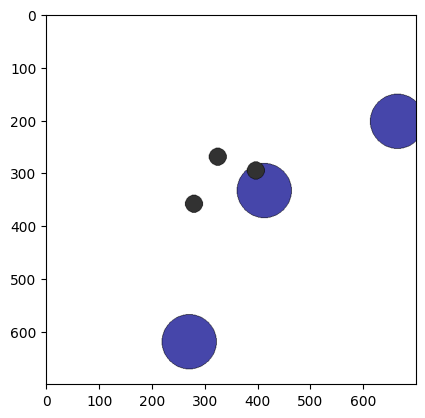

-27.57182694656241


In [10]:
eval_env = simple_spread_v3.env(
    N=num_agents,
    max_cycles=25,
    local_ratio=0.5,
    continuous_actions=False,
    render_mode="rgb_array"
)

import matplotlib.pyplot as plt
from IPython.display import clear_output
from tianshou.data import Batch
fig, ax = plt.subplots(figsize=(5, 5))
ep_rewards = []
num_episodes = 1
for ep in range(num_episodes):
    eval_env.reset(seed=42)
    total_reward = {agent: 0 for agent in eval_env.agents}
    for agent in eval_env.agent_iter():
        observation, reward, termination, trunc, info = eval_env.last()
        total_reward[agent] += reward
        if (termination or trunc):
            ep_rewards.append(total_reward[agent])
            action = None
        else:
            batch = Batch(obs=[observation], info=info)
            agent_id = int(str(agent).split('_')[1])
            action = policy.policies[agents[agent_id]](batch).act[0]
        eval_env.step(action)
        img = eval_env.render()
        plt.imshow(img)
        clear_output(wait=True)
        plt.pause(0.1)

print(np.mean(ep_rewards))

In [11]:
from pettingzoo.mpe.simple_spread.simple_spread import Scenario, raw_env
from gymnasium.utils import EzPickle
from pettingzoo.mpe._mpe_utils.core import Agent, Landmark, World
from pettingzoo.mpe._mpe_utils.scenario import BaseScenario
from pettingzoo.mpe._mpe_utils.simple_env import SimpleEnv, make_env

class Scenario_change_reward(Scenario):
    def reward(self, agent, world):
        rew = 0
        if agent.collide:
            for a in world.agents:
                rew -= 2.0 * (self.is_collision(a, agent) and a != agent)
        return rew
    
class raw_env_change_reward(raw_env):
    def __init__(
        self,
        N=3,
        local_ratio=0.5,
        max_cycles=25,
        continuous_actions=False,
        render_mode=None,
    ):
        EzPickle.__init__(
            self,
            N=N,
            local_ratio=local_ratio,
            max_cycles=max_cycles,
            continuous_actions=continuous_actions,
            render_mode=render_mode,
        )
        assert (
            0.0 <= local_ratio <= 1.0
        ), "local_ratio is a proportion. Must be between 0 and 1."
        scenario = Scenario_change_reward()  # change scenario
        world = scenario.make_world(N)
        SimpleEnv.__init__(
            self,
            scenario=scenario,
            world=world,
            render_mode=render_mode,
            max_cycles=max_cycles,
            continuous_actions=continuous_actions,
            local_ratio=local_ratio,
        )
        self.metadata["name"] = "simple_spread_v3"

env_change_reward = make_env(raw_env_change_reward)
env_change_reward = env_change_reward(N=3, max_cycles=25, local_ratio=0.5, continuous_actions=False, render_mode="rgb_array")